# 1. 자전거 대여 예측

In [61]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 통계적 모형
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 머신러닝
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error

In [18]:
rawData = pd.read_csv('./data/london_merged.csv')

In [19]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [20]:
rawData.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [21]:
rawData.weather_code.unique()

array([ 3.,  1.,  4.,  7.,  2., 26., 10.])

In [22]:
rawData.is_holiday.unique()

array([0., 1.])

In [23]:
rawData.is_weekend.unique()

array([1., 0.])

In [24]:
rawData.season.unique()

array([3., 0., 1., 2.])

In [25]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# 1. 전처리

## 1. 인덱스 지정

In [26]:
rawData['timestamp']

0        2015-01-04 00:00:00
1        2015-01-04 01:00:00
2        2015-01-04 02:00:00
3        2015-01-04 03:00:00
4        2015-01-04 04:00:00
                ...         
17409    2017-01-03 19:00:00
17410    2017-01-03 20:00:00
17411    2017-01-03 21:00:00
17412    2017-01-03 22:00:00
17413    2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: object

- 문자열로 취급되기 때문에, 변환을 통해 시간타입으로 바꿔줘야 한다. 

In [28]:
rawData['timestamp'] = pd.to_datetime(rawData['timestamp'])

In [29]:
rawData['datetime'] = rawData['timestamp']

In [30]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,datetime
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015-01-04 00:00:00
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015-01-04 01:00:00
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015-01-04 02:00:00
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015-01-04 03:00:00
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015-01-04 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017-01-03 19:00:00
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017-01-03 20:00:00
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017-01-03 21:00:00
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,2017-01-03 22:00:00


In [31]:
rawData.set_index('datetime', inplace=True)

In [32]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
datetime,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [33]:
rawData.index

DatetimeIndex(['2015-01-04 00:00:00', '2015-01-04 01:00:00',
               '2015-01-04 02:00:00', '2015-01-04 03:00:00',
               '2015-01-04 04:00:00', '2015-01-04 05:00:00',
               '2015-01-04 06:00:00', '2015-01-04 07:00:00',
               '2015-01-04 08:00:00', '2015-01-04 09:00:00',
               ...
               '2017-01-03 14:00:00', '2017-01-03 15:00:00',
               '2017-01-03 16:00:00', '2017-01-03 17:00:00',
               '2017-01-03 18:00:00', '2017-01-03 19:00:00',
               '2017-01-03 20:00:00', '2017-01-03 21:00:00',
               '2017-01-03 22:00:00', '2017-01-03 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17414, freq=None)

In [37]:
# rawData.asfreq('D')
# rawData.asfreq('W')
# rawData.asfreq('M')
rawData = rawData.asfreq('H')

In [38]:
rawData.index

DatetimeIndex(['2015-01-04 00:00:00', '2015-01-04 01:00:00',
               '2015-01-04 02:00:00', '2015-01-04 03:00:00',
               '2015-01-04 04:00:00', '2015-01-04 05:00:00',
               '2015-01-04 06:00:00', '2015-01-04 07:00:00',
               '2015-01-04 08:00:00', '2015-01-04 09:00:00',
               ...
               '2017-01-03 14:00:00', '2017-01-03 15:00:00',
               '2017-01-03 16:00:00', '2017-01-03 17:00:00',
               '2017-01-03 18:00:00', '2017-01-03 19:00:00',
               '2017-01-03 20:00:00', '2017-01-03 21:00:00',
               '2017-01-03 22:00:00', '2017-01-03 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17544, freq='H')

## 2. 결측치 확인

In [43]:
rawData.isna().sum()

timestamp       130
cnt             130
t1              130
t2              130
hum             130
wind_speed      130
weather_code    130
is_holiday      130
is_weekend      130
season          130
dtype: int64

In [44]:
rawData.loc[rawData.timestamp.isna()]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
datetime,,,,,,,,,,
2015-01-07 19:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-10 21:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-29 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2016-09-03 09:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-03 10:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-03 11:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
rawData.dropna(inplace=True)

In [47]:
rawData.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

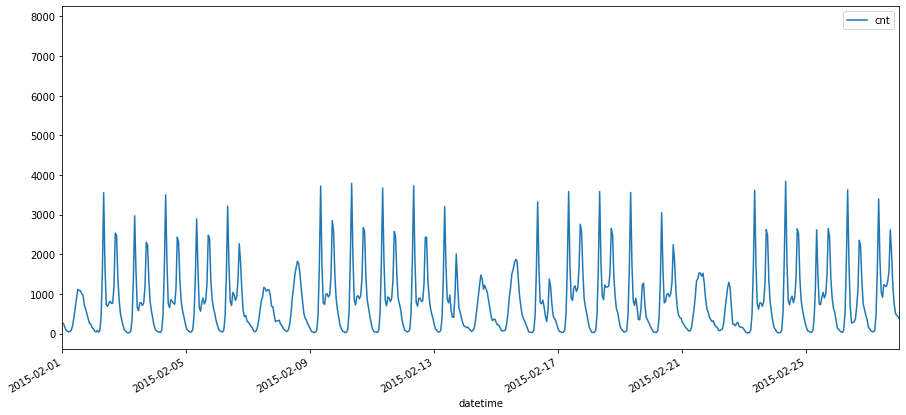

In [48]:
rawData[['cnt']].plot(figsize=(15, 7), xlim=('2015-02-01', '2015-02-28'))
plt.show()

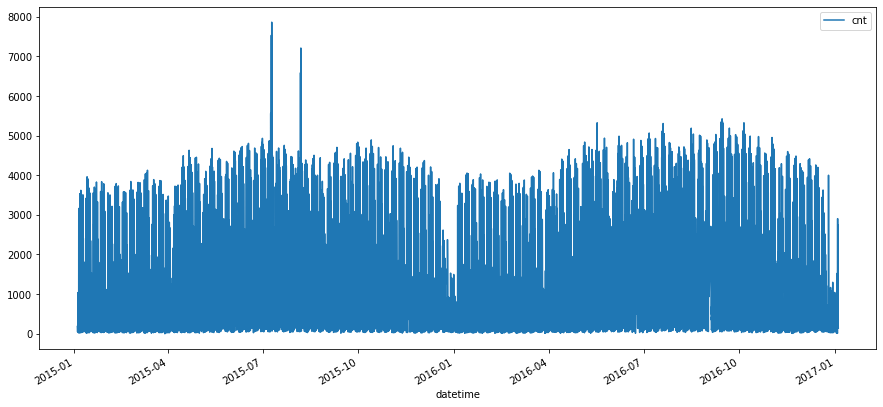

In [49]:
rawData[['cnt']].plot(figsize=(15, 7))
plt.show()

## 3.Feature Engineering 
- Feature Extraction
- Featrue Selection

### 1. 시간

In [50]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
datetime,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [54]:
# rawData['timestamp'].dt.year
# rawData['timestamp'].dt.month
# rawData['timestamp'].dt.day
rawData['timestamp'].dt.dayofweek

datetime
2015-01-04 00:00:00    6
2015-01-04 01:00:00    6
2015-01-04 02:00:00    6
2015-01-04 03:00:00    6
2015-01-04 04:00:00    6
                      ..
2017-01-03 19:00:00    1
2017-01-03 20:00:00    1
2017-01-03 21:00:00    1
2017-01-03 22:00:00    1
2017-01-03 23:00:00    1
Name: timestamp, Length: 17414, dtype: int64

In [55]:
rawData['year'] = rawData.timestamp.dt.year

In [56]:
rawData['month'] = rawData.timestamp.dt.month

In [57]:
rawData['day'] = rawData.timestamp.dt.day

In [58]:
rawData['hour'] = rawData.timestamp.dt.hour

In [59]:
rawData['dayofweek'] = rawData.timestamp.dt.dayofweek

In [60]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek
datetime,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,0,6
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,1,6
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,4,2,6
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,4,3,6
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017,1,3,19,1
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017,1,3,20,1
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017,1,3,21,1


### 2. LAG(지연)

In [26]:
rawData['cnt'].shift(1)

datetime
2015-01-04 00:00:00       NaN
2015-01-04 01:00:00     182.0
2015-01-04 02:00:00     138.0
2015-01-04 03:00:00     134.0
2015-01-04 04:00:00      72.0
                        ...  
2017-01-03 19:00:00    2220.0
2017-01-03 20:00:00    1042.0
2017-01-03 21:00:00     541.0
2017-01-03 22:00:00     337.0
2017-01-03 23:00:00     224.0
Freq: H, Name: cnt, Length: 17544, dtype: float64

In [62]:
rawData['cnt'].shift(2)

datetime
2015-01-04 00:00:00       NaN
2015-01-04 01:00:00       NaN
2015-01-04 02:00:00     182.0
2015-01-04 03:00:00     138.0
2015-01-04 04:00:00     134.0
                        ...  
2017-01-03 19:00:00    2742.0
2017-01-03 20:00:00    2220.0
2017-01-03 21:00:00    1042.0
2017-01-03 22:00:00     541.0
2017-01-03 23:00:00     337.0
Name: cnt, Length: 17414, dtype: float64

In [63]:
rawData['lag_cnt1'] = rawData['cnt'].shift(1)
rawData['lag_cnt2'] = rawData['cnt'].shift(2)

In [65]:
rawData['lag_cnt1'].fillna(method='bfill', inplace=True)
rawData['lag_cnt2'].fillna(method='bfill', inplace=True)

In [66]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek,lag_cnt1,lag_cnt2
datetime,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,0,6,182.0,182.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,1,6,182.0,182.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,4,2,6,138.0,182.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,4,3,6,134.0,138.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,4,6,72.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017,1,3,19,1,2220.0,2742.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017,1,3,20,1,1042.0,2220.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017,1,3,21,1,541.0,1042.0


### 3. 차분

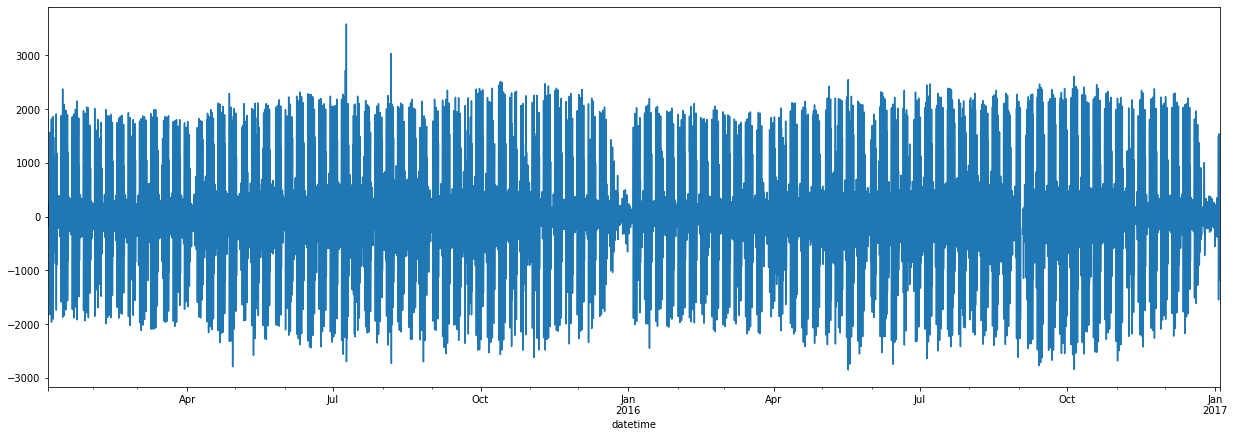

In [30]:
rawData['cnt'].diff().plot(kind='line', figsize=(21, 7))
plt.show()

In [67]:
rawData['diff'] = rawData['cnt'].diff()

In [68]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek,lag_cnt1,lag_cnt2,diff
datetime,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,0,6,182.0,182.0,NaN
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,1,6,182.0,182.0,-44.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,4,2,6,138.0,182.0,-4.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,4,3,6,134.0,138.0,-62.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,4,6,72.0,134.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017,1,3,19,1,2220.0,2742.0,-1178.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017,1,3,20,1,1042.0,2220.0,-501.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017,1,3,21,1,541.0,1042.0,-204.0


In [69]:
rawData['diff'].fillna(method='bfill', inplace=True)

In [34]:
rawData

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day,hour,dayofweek,lag_cnt1,lag_cnt2,diff
datetime,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015.0,1.0,4.0,0.0,6.0,182.0,182.0,-44.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,1.0,6.0,182.0,182.0,-44.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,2.0,6.0,138.0,182.0,-4.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,3.0,6.0,134.0,138.0,-62.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015.0,1.0,4.0,4.0,6.0,72.0,134.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042.0,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,2017.0,1.0,3.0,19.0,1.0,2220.0,2742.0,-1178.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541.0,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,20.0,1.0,1042.0,2220.0,-501.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337.0,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,2017.0,1.0,3.0,21.0,1.0,541.0,1042.0,-204.0


In [70]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  float64       
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
 10  year          17414 non-null  int64         
 11  month         17414 non-null  int64         
 12  day           17414 non-null  int64         
 13  hour          17414 non-null  int64         
 14  dayofweek     17414 non-null  int64         
 15  l

# 2. EDA(Exploratory Data Analysis)
- 통계적 수치와 그림을 통한 탐색적 데이터 분석
- 이 과정을 통해서 데이터에 대한 이해도를 높일 수 있다. 
- 추출된 변수들과 반응변수 사이의 관계도 시각적으로 확인

In [76]:
rawData['cnt'] = rawData['cnt'].astype(np.int)

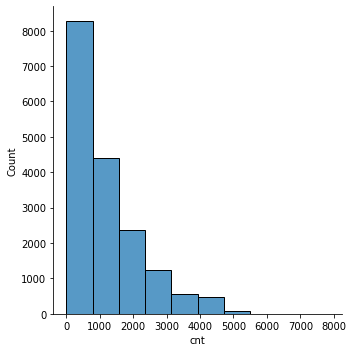

In [80]:
sns.displot(rawData, x='cnt', bins=10)
plt.show()

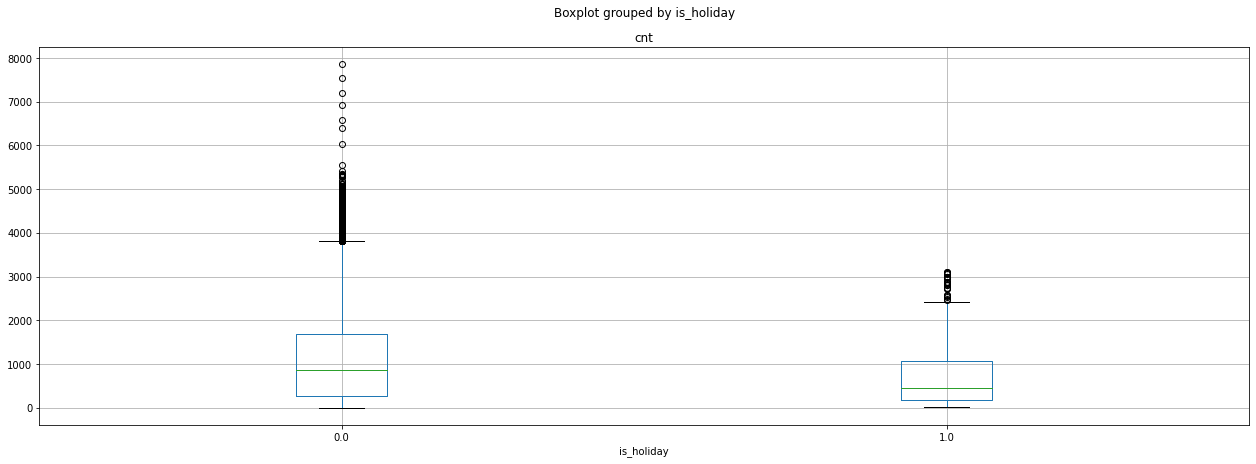

In [81]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='is_holiday', grid=True, figsize=(21,7))
plt.show()

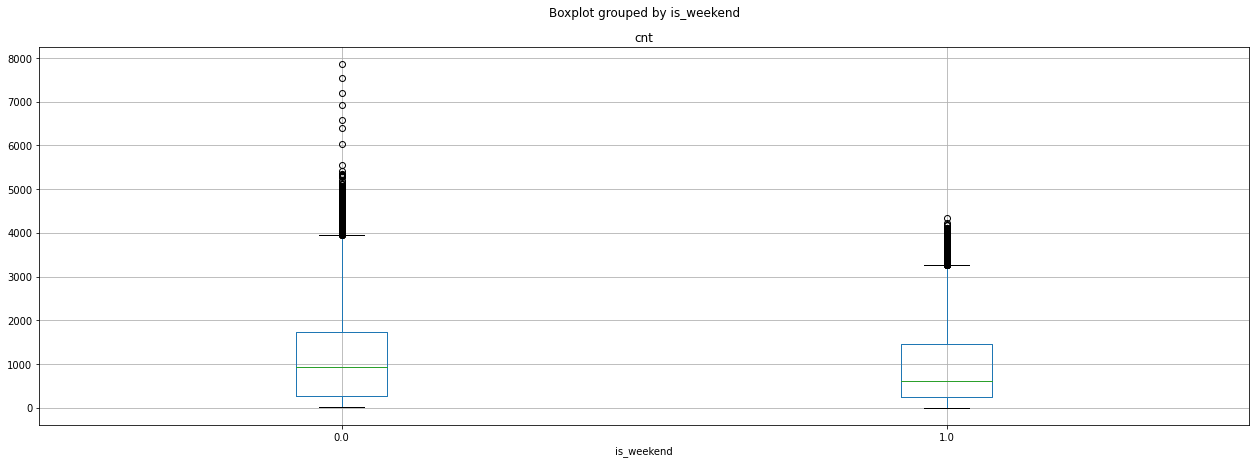

In [37]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='is_weekend', grid=True, figsize=(21,7))
plt.show()

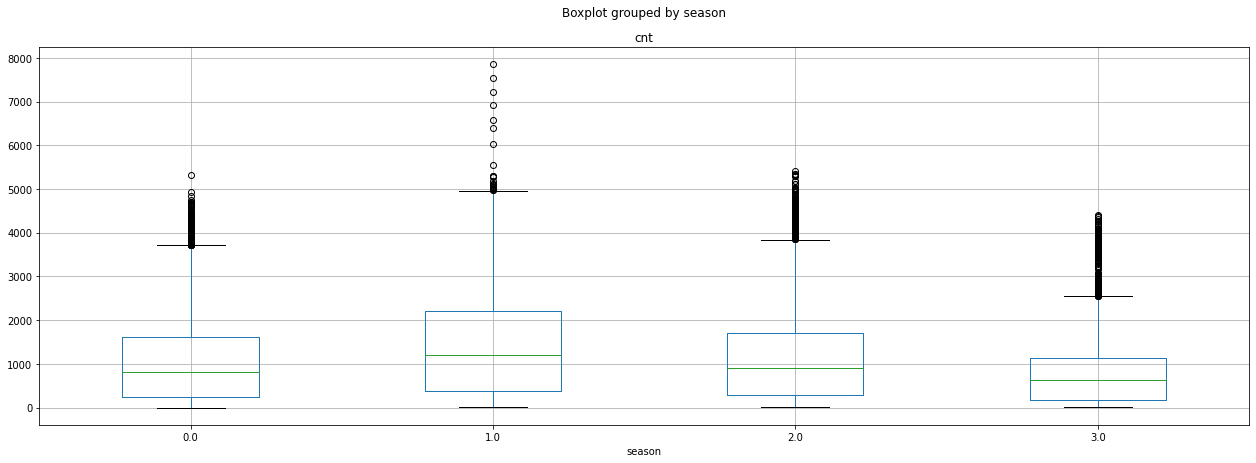

In [38]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='season', grid=True, figsize=(21,7))
plt.show()

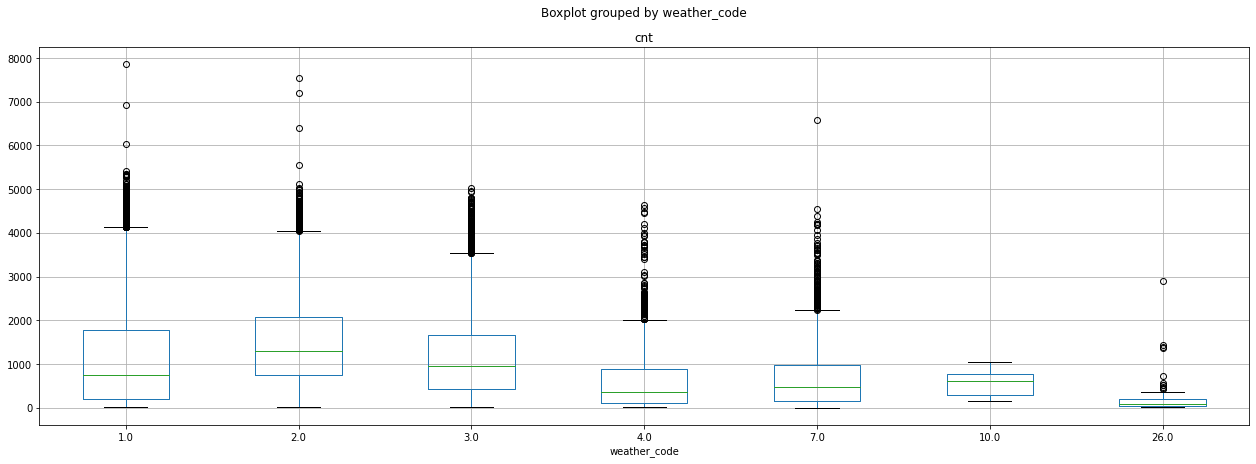

In [39]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='weather_code', grid=True, figsize=(21,7))
plt.show()

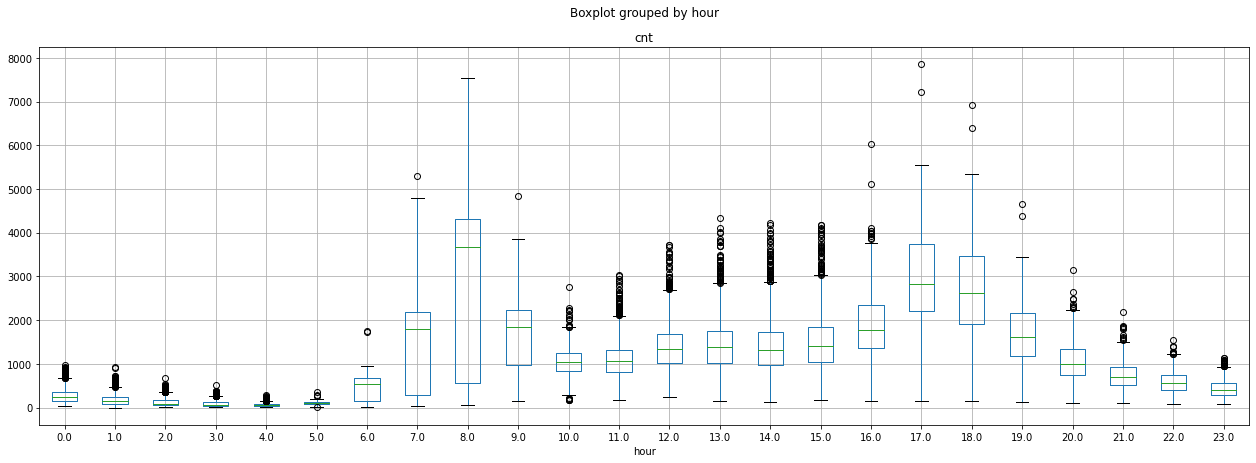

In [40]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='hour', grid=True, figsize=(21,7))
plt.show()

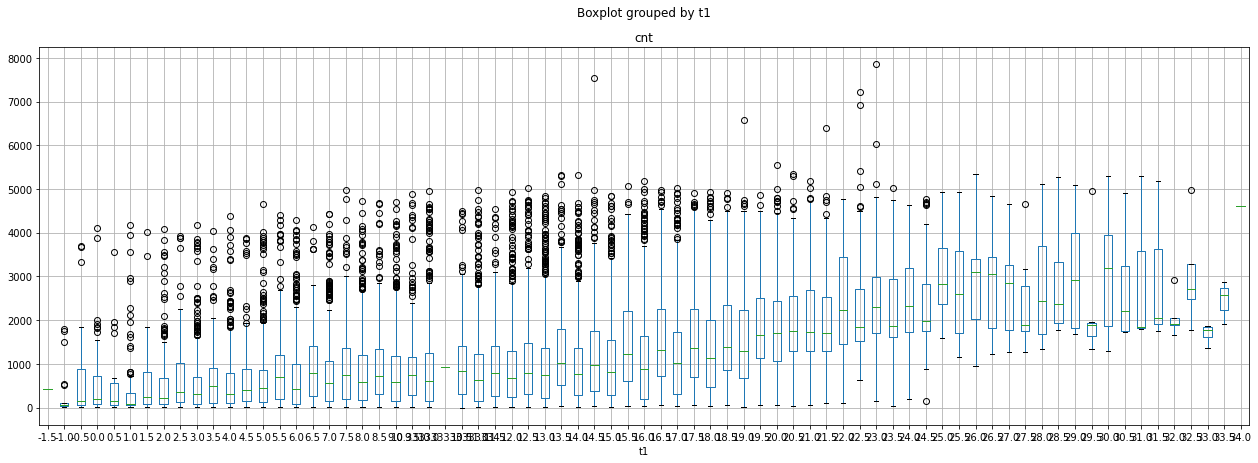

In [82]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='t1', grid=True, figsize=(21,7))
plt.show()

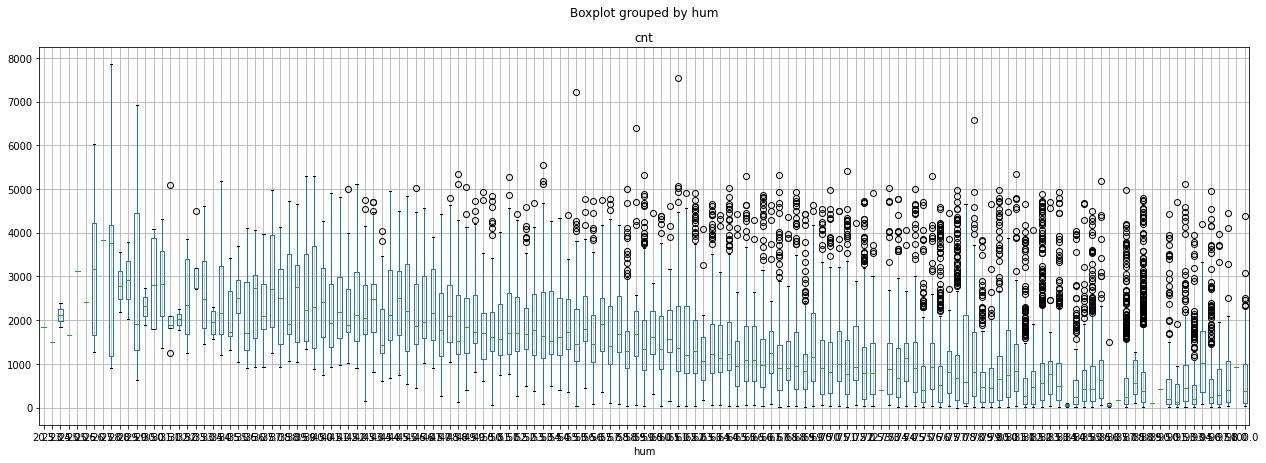

In [83]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='hum', grid=True, figsize=(21,7))
plt.show()

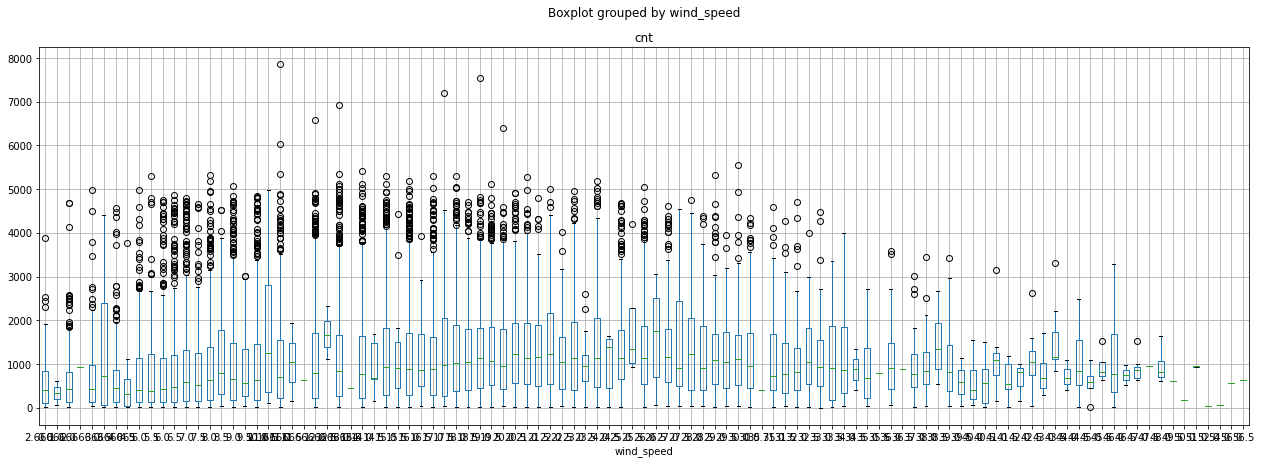

In [84]:
# box-plot, scatter plot, histogram, ... 
rawData.boxplot(column='cnt', by='wind_speed', grid=True, figsize=(21,7))
plt.show()

# 3. 선형회귀를 통한 자전거 대여수 예측

### 1. 학습 / 테스트 셋을 분리
- 시계열 데이터와 같은 경우는 과거의 데이터로 학습, 미래의 데이터로 검증

In [86]:
rawTrain = rawData.loc[rawData.index < '2016-08-01', :]
rawTest = rawData.loc[rawData.index >= '2016-08-01', :]
print(rawTrain.shape, rawTest.shape)

(13713, 18) (3701, 18)


In [88]:
x_train = rawTrain.loc[:,'t1':]
y_train = rawTrain[['cnt']]
x_test = rawTest.loc[:, 't1':]
y_test = rawTest[['cnt']]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(13713, 16) (13713, 1)
(3701, 16) (3701, 1)


### 2. 선형회귀모형 적합

In [89]:
model1 = sm.OLS(y_train, x_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    cnt   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.463e+10
Date:                Sun, 24 Jan 2021   Prob (F-statistic):                        0.00
Time:                        06:32:26   Log-Likelihood:                         -6025.9
No. Observations:               13713   AIC:                                  1.208e+04
Df Residuals:                   13697   BIC:                                  1.220e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
t1              -0.0075      0.004     -1.753      0.080      -0.016       0.001
t2               0.0063      0.004      1.763      0.078      -0.001       0.013
hum              0.0001      0.000      0.352      0.725      -0.001       0.001
wind_speed      -0.0001      0.000     -0.323      0.746      -0.001       0.001
weather_code    -0.0002      0.001     -0.149      0.881      -0.003       0.003
is_holiday       0.0036      0.023      0.157      0.875      -0.041       0.048
is_weekend       0.0083      0.012      0.709      0.479      -0.015       0.031
season           0.0045      0.003      1.507      0.132      -0.001       0.010
year          1.622e-05   1.64e-05      0.991      0.322   -1.59e-05    4.83e-05
month           -0.0021      0.001     -1.642      0.101      -0.005       0.000
day             -0.0005      0.000     -1.323      0.186      -0.001       0.000
hour            -0.0008      0.001     -1.492      0.136      -0.002       0.000
dayofweek        0.0011      0.003      0.428      0.669      -0.004       0.006
lag_cnt1         1.0000   4.98e-06   2.01e+05      0.000       1.000       1.000
lag_cnt2      2.511e-06   5.85e-06      0.429      0.668   -8.95e-06     1.4e-05
diff             1.0000   5.62e-06   1.78e+05      0.000       1.000       1.000
==============================================================================
Omnibus:                    57247.303   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     106875787199.195
Skew:                         116.876   Prob(JB):                         0.00
Kurtosis:                   13677.631   Cond. No.                     1.95e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3. 테스트 정확도/에러

In [93]:
predict_test = model1.predict(x_test).values

In [94]:
predict_test

array([372.00412765, 203.0033995 , 125.00314889, ..., 337.00213249,
       223.99983688, 138.9996444 ])

In [95]:
pd.concat([y_test, pd.DataFrame(predict_test, index=y_test.index, columns=['predict'])], axis=1)

,cnt,predict
datetime,,
2016-08-01 00:00:00,372,372.004128
2016-08-01 01:00:00,203,203.003400
2016-08-01 02:00:00,125,125.003149
2016-08-01 03:00:00,79,79.003066
2016-08-01 04:00:00,79,79.003118
...,...,...
2017-01-03 19:00:00,1042,1042.010412
2017-01-03 20:00:00,541,541.007396
2017-01-03 21:00:00,337,337.002132


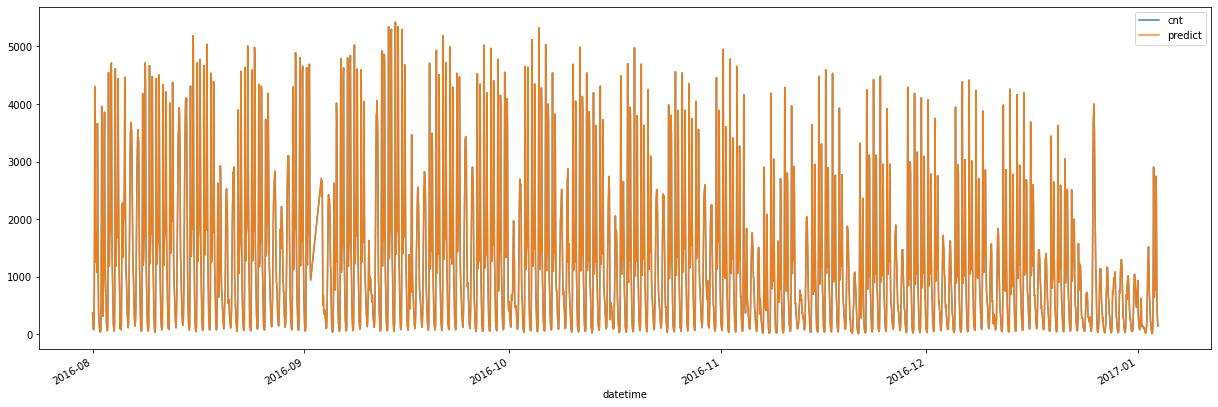

In [96]:
pd.concat([y_test, pd.DataFrame(predict_test, index=y_test.index, columns=['predict'])], axis=1).plot(
    kind='line', figsize=(21,7), alpha=0.9,
    linewidth=1.5
)
plt.show()

In [99]:
print( mean_absolute_error(y_true=y_test, y_pred=predict_test) )
print( mean_squared_error(y_true=y_test, y_pred=predict_test) )
print( r2_score(y_true=y_test, y_pred=predict_test) )

0.008978930923089113
0.0001307584826647682
0.9999999998996807


### 4. 잔차 확인

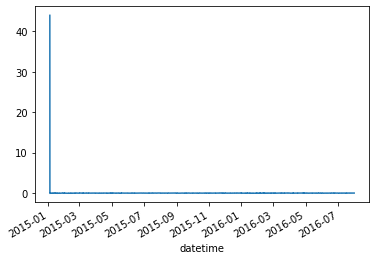

In [106]:
model1.resid.plot()
plt.show()